# Ensemble Volatility

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import timeit

import warnings
warnings.filterwarnings("ignore")

# List of Stocks and ETFs
Provided by Thomas Choi.

In [2]:
stock_list = pd.read_csv("../stocks_and_etfs/stock_list.csv")
etf_list = pd.read_csv("../stocks_and_etfs/etf_list.csv")

In [3]:
import random

# Choose a random stock
stock_symbol = random.choice(stock_list.iloc[:,0])
print(stock_symbol)

CLF


## MySQL connection
Choosing one stock from SQL query to reduce query time.

In [4]:
import os
import sys
import mysql.connector

HOST="143.244.188.157"
PORT="3306"
USER="patrick-finProj"
PASSWORD="Pat#21$rick"

try: 
    conn = mysql.connector.connect(
        host=HOST,
        port=PORT,
        user=USER,
        password=PASSWORD,
        database="GlobalMarketData"
    )
    query = f"SELECT Date, Close, Open, High, Low, Volume from histdailyprice3 WHERE Symbol='{stock_symbol}';"
    histdailyprice3 = pd.read_sql(query, conn)
    conn.close()
except Exception as e:
    conn.close()
    print(str(e))

# Data

In [5]:
df = histdailyprice3.copy()

In [6]:
df.head()

,Date,Close,Open,High,Low,Volume
0,1998-01-01,5.728,5.728,5.728,5.728,0
1,1998-01-02,5.735,5.813,5.703,5.813,34800
2,1998-01-05,5.813,5.838,5.805,5.828,211800
3,1998-01-06,5.828,5.828,5.720,5.735,58200
4,1998-01-07,5.728,5.805,5.695,5.783,87800


In [7]:
returns = 100 * df['Close'].pct_change().dropna()
realized_vol = returns.rolling(5).std()

In [8]:
n = int(len(returns)*0.4)
split_date = returns[-n:].index

# ARCH

In [9]:
from arch import arch_model
model = arch_model(returns, mean='Zero', vol='ARCH', p=1, o=0, q=0)
model_fitted = model.fit(disp='off')
print(model_fitted.summary())

                        Zero Mean - ARCH Model Results                        
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -23555.3
Distribution:                  Normal   AIC:                           47114.6
Method:            Maximum Likelihood   BIC:                           47128.1
                                        No. Observations:                 6176
Date:                Fri, Jan 07 2022   Df Residuals:                     6176
Time:                        16:35:57   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega        117.7081     36.834      3.196  1.395e-03  [ 45.

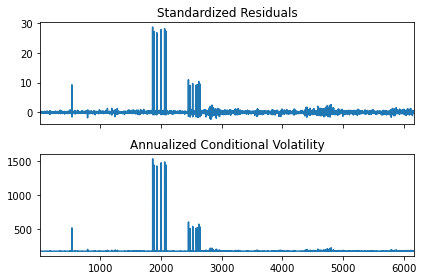

In [10]:
model_fitted.plot(annualize='D')

plt.tight_layout()
plt.show()

In [11]:
model = arch_model(returns, mean='Zero', vol='ARCH', p=1, o=0, q=0)
model_fit = model.fit(disp='off')
pred = model_fit.forecast(horizon=1)

In [12]:
bic_arch = []

for p in range(1, 5):
    arch = arch_model(returns, mean='zero', vol='ARCH', p=p).fit(disp='off')
    bic_arch.append(arch.bic)
    if arch.bic == np.min(bic_arch):
         best_param = p
arch = arch_model(returns, mean='zero', vol='ARCH', p=best_param).fit(disp='off')
print(arch.summary())
forecast = arch.forecast(start=split_date[0])
forecast_arch = forecast

                        Zero Mean - ARCH Model Results                        
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -23555.3
Distribution:                  Normal   AIC:                           47114.6
Method:            Maximum Likelihood   BIC:                           47128.1
                                        No. Observations:                 6176
Date:                Fri, Jan 07 2022   Df Residuals:                     6176
Time:                        16:35:58   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega        117.7081     36.834      3.196  1.395e-03  [ 45.

In [13]:
from sklearn.metrics import mean_squared_error as mse

forecast_arch.variance

,h.1
1,NaN
2,NaN
3,NaN
4,NaN
5,NaN
...,...
6172,118.044316
6173,118.222786
6174,118.407136
6175,118.905316


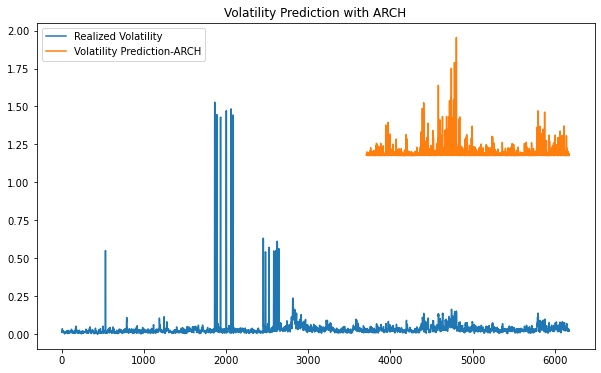

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_arch.variance.iloc[-len(split_date):] / 100, label='Volatility Prediction-ARCH')
plt.title('Volatility Prediction with ARCH', fontsize=12)
plt.legend()
plt.show()

In [15]:
rmse_arch = np.sqrt(mse(realized_vol[-n:] / 100, np.sqrt(forecast_arch.variance.iloc[-len(split_date):].fillna(0) / 100)))
print('The RMSE value of ARCH model is {:.4f}'.format(rmse_arch))

The RMSE value of ARCH model is 1.0553


# GARCH

In [16]:
garch = arch_model(returns, mean='zero', vol='GARCH', p=1, o=0, q=1).fit(disp='off')
print(garch.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -21179.9
Distribution:                  Normal   AIC:                           42365.7
Method:            Maximum Likelihood   BIC:                           42385.9
                                        No. Observations:                 6176
Date:                Fri, Jan 07 2022   Df Residuals:                     6176
Time:                        16:35:58   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.8251      0.504      1.638      0.101    

In [17]:
bic_garch = []

for p in range(1, 5):
    for q in range(1, 5):
        garch = arch_model(returns, mean='zero', vol='GARCH', p=p, o=0, q=q).fit(disp='off')
        bic_garch.append(garch.bic)
        if garch.bic == np.min(bic_garch):
            best_param = p, q
garch = arch_model(returns, mean='zero', vol='GARCH',
                p=best_param[0], o=0, q=best_param[1]).fit(disp='off')
print(garch.summary())
forecast = garch.forecast(start=split_date[0])
forecast_garch = forecast

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -20977.6
Distribution:                  Normal   AIC:                           41969.3
Method:            Maximum Likelihood   BIC:                           42016.4
                                        No. Observations:                 6176
Date:                Fri, Jan 07 2022   Df Residuals:                     6176
Time:                        16:35:59   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          3.2570      2.232      1.459      0.145 

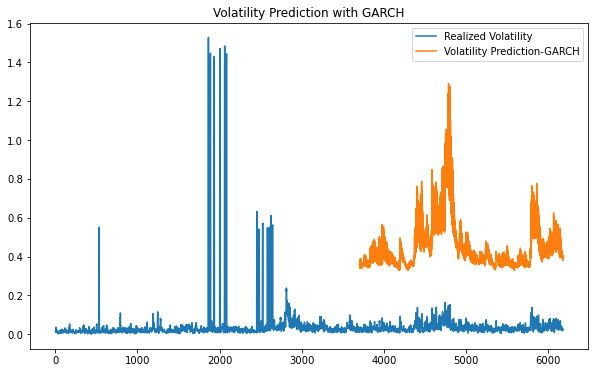

In [18]:
plt.figure(figsize=(10,6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_garch.variance.iloc[-len(split_date):] / 100, label='Volatility Prediction-GARCH')
plt.title('Volatility Prediction with GARCH', fontsize=12)
plt.legend()
plt.show()

In [19]:
rmse_garch = np.sqrt(mse(realized_vol[-n:] / 100, np.sqrt(forecast_garch.variance.iloc[-len(split_date):].fillna(0) / 100)))
print('The RMSE value of GARCH model is {:.4f}'.format(rmse_garch))

The RMSE value of GARCH model is 0.6327


# GJR GARCH

In [20]:
bic_gjr_garch = []

for p in range(1, 5):
    for q in range(1, 5):
        gjrgarch = arch_model(returns, mean='zero', p=p, o=1, q=q).fit(disp='off')
        bic_gjr_garch.append(gjrgarch.bic)
        if gjrgarch.bic == np.min(bic_gjr_garch):
             best_param = p, q
gjrgarch = arch_model(returns, mean='zero', p=best_param[0], o=1, q=best_param[1]).fit(disp='off')
print(gjrgarch.summary())
forecast = gjrgarch.forecast(start=split_date[0])
forecast_gjrgarch = forecast

bic_garch = []

C:\Users\Patrick.Guo\.conda\envs\rtx3000s\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\Patrick.Guo\.conda\envs\rtx3000s\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


                     Zero Mean - GJR-GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -21050.7
Distribution:                  Normal   AIC:                           42115.5
Method:            Maximum Likelihood   BIC:                           42162.6
                                        No. Observations:                 6176
Date:                Fri, Jan 07 2022   Df Residuals:                     6176
Time:                        16:36:02   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          3.0954      1.660      1.865  6.220e-02    [ -

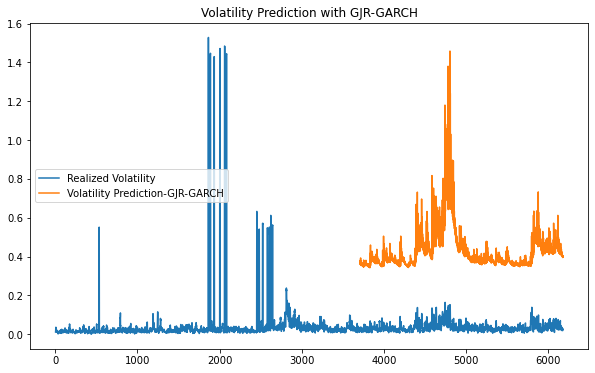

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_gjrgarch.variance.iloc[-len(split_date):] / 100, label='Volatility Prediction-GJR-GARCH')
plt.title('Volatility Prediction with GJR-GARCH', fontsize=12)
plt.legend()
plt.show()

In [22]:
rmse_gjr_garch = np.sqrt(mse(realized_vol[-n:] / 100, np.sqrt(forecast_gjrgarch.variance.iloc[-len(split_date):].fillna(0) / 100)))
print('The RMSE value of GJR-GARCH models is {:.4f}'.format(rmse_gjr_garch))

The RMSE value of GJR-GARCH models is 0.6158


# EGARCH

In [23]:
bic_egarch = []

for p in range(1, 5):
    for q in range(1, 5):
        egarch = arch_model(returns, mean='zero', vol='EGARCH', p=p, q=q).fit(disp='off')
        bic_egarch.append(egarch.bic)
        if egarch.bic == np.min(bic_egarch):
            best_param = p, q
    egarch = arch_model(returns, mean='zero', vol='EGARCH', p=best_param[0], q=best_param[1]).fit(disp='off')
print(egarch.summary())
forecast = egarch.forecast(start=split_date[0])
forecast_egarch = forecast

C:\Users\Patrick.Guo\.conda\envs\rtx3000s\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\Patrick.Guo\.conda\envs\rtx3000s\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\Patrick.Guo\.conda\envs\rtx3000s\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


                       Zero Mean - EGARCH Model Results                       
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -20778.4
Distribution:                  Normal   AIC:                           41570.9
Method:            Maximum Likelihood   BIC:                           41618.0
                                        No. Observations:                 6176
Date:                Fri, Jan 07 2022   Df Residuals:                     6176
Time:                        16:36:05   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0653  2.581e-03     25.297 3.411e-141 

C:\Users\Patrick.Guo\.conda\envs\rtx3000s\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


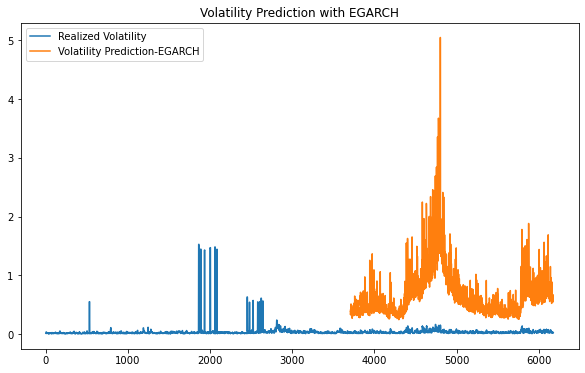

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_egarch.variance.iloc[-len(split_date):] / 100, label='Volatility Prediction-EGARCH')
plt.title('Volatility Prediction with EGARCH', fontsize=12)
plt.legend()
plt.show()

In [25]:
rmse_egarch = np.sqrt(mse(realized_vol[-n:] / 100, np.sqrt(forecast_egarch.variance.iloc[-len(split_date):].fillna(0) / 100)))
print('The RMSE value of EGARCH models is {:.4f}'.format(rmse_egarch))

The RMSE value of EGARCH models is 0.7756


# SVR GARCH

In [26]:
from sklearn.svm import SVR
from scipy.stats import uniform as sp_rand
from sklearn.model_selection import RandomizedSearchCV

In [27]:
# Compute realized volatility
realized_vol = returns.rolling(5).std()
realized_vol = pd.DataFrame(realized_vol)
realized_vol.reset_index(drop=True, inplace=True)

returns_svm = returns ** 2
returns_svm = returns_svm.reset_index()
del returns_svm['index']

X = pd.concat([realized_vol, returns_svm], axis=1, ignore_index=True)
X = X[4:].copy()
X = X.reset_index()
X.drop('index', axis=1, inplace=True)

realized_vol = realized_vol.dropna().reset_index()
realized_vol.drop('index', axis=1, inplace=True)

svr_poly = SVR(kernel='poly', degree=2)
svr_lin = SVR(kernel='linear')
svr_rbf = SVR(kernel='rbf')

## Linear

In [28]:
start = timeit.default_timer()

para_grid = {'gamma': sp_rand(), 'C': sp_rand(), 'epsilon': sp_rand()}
clf = RandomizedSearchCV(svr_lin, para_grid)
clf.fit(X.iloc[:-n].values, realized_vol.iloc[1:-(n-1)].values.reshape(-1,))
predict_svr_lin = clf.predict(X.iloc[-n:])

predict_svr_lin = pd.DataFrame(predict_svr_lin)
predict_svr_lin.index = returns.iloc[-n:].index

rmse_svr = np.sqrt(mse(realized_vol.iloc[-n:] / 100, predict_svr_lin / 100))
print('The RMSE value of SVR with Linear Kernel is {:.6f}'.format(rmse_svr))

stop = timeit.default_timer()
print('Time: ', stop - start)

The RMSE value of SVR with Linear Kernel is 0.000277
Time:  2704.7660622


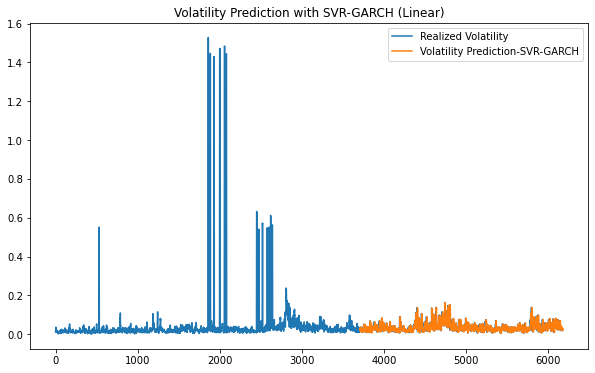

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(predict_svr_lin / 100, label='Volatility Prediction-SVR-GARCH')
plt.title('Volatility Prediction with SVR-GARCH (Linear)', fontsize=12)
plt.legend()
plt.show()

In [30]:
rmse_svr = np.sqrt(mse(realized_vol.iloc[-n:] / 100, predict_svr_lin / 100))
print('The RMSE value of SVR with Linear Kernel is {:.6f}'.format(rmse_svr))

The RMSE value of SVR with Linear Kernel is 0.000277


## Radial basis function

In [31]:
start = timeit.default_timer()

para_grid ={'gamma': sp_rand(), 'C': sp_rand(), 'epsilon': sp_rand()}
clf = RandomizedSearchCV(svr_rbf, para_grid)
clf.fit(X.iloc[:-n].values, realized_vol.iloc[1:-(n-1)].values.reshape(-1,))
predict_svr_rbf = clf.predict(X.iloc[-n:])

predict_svr_rbf = pd.DataFrame(predict_svr_rbf)
predict_svr_rbf.index = returns.iloc[-n:].index

stop = timeit.default_timer()
print('Time: ', stop - start)

Time:  18.915308300000106


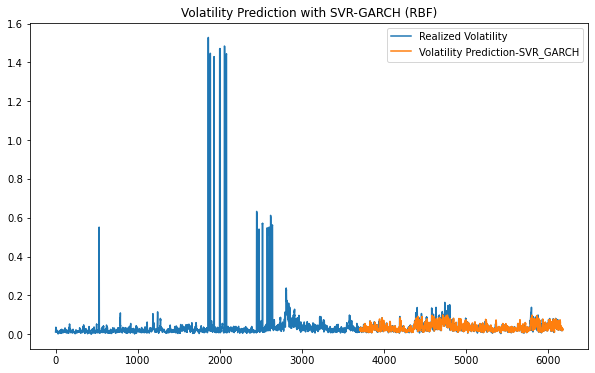

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(predict_svr_rbf / 100, label='Volatility Prediction-SVR_GARCH')
plt.title('Volatility Prediction with SVR-GARCH (RBF)', fontsize=12)
plt.legend()
plt.show()

In [33]:
rmse_svr_rbf = np.sqrt(mse(realized_vol.iloc[-n:] / 100, predict_svr_rbf / 100))
print('The RMSE value of SVR with RBF Kernel is  {:.6f}'.format(rmse_svr_rbf))

The RMSE value of SVR with RBF Kernel is  0.008561


## Polynomial Kernal
Long run time 

In [34]:
#start = timeit.default_timer()

#para_grid = {'gamma': sp_rand(), 'C': sp_rand(), 'epsilon': sp_rand()}
#clf = RandomizedSearchCV(svr_poly, para_grid)
#clf.fit(X.iloc[:-n].values, realized_vol.iloc[1:-(n-1)].values.reshape(-1,))
#predict_svr_poly = clf.predict(X.iloc[-n:])

#predict_svr_poly = pd.DataFrame(predict_svr_poly)
#predict_svr_poly.index = returns.iloc[-n:].index

#stop = timeit.default_timer()
#print('Time: ', stop - start)

In [35]:
#plt.figure(figsize=(10, 6))
#plt.plot(realized_vol/100, label='Realized Volatility')
#plt.plot(predict_svr_poly/100, label='Volatility Prediction-SVR-GARCH')
#plt.title('Volatility Prediction with SVR-GARCH (Polynomial)', fontsize=12)
#plt.legend()
#plt.show()

In [36]:
#rmse_svr_poly = np.sqrt(mse(realized_vol.iloc[-n:] / 100, predict_svr_poly / 100))
#print('The RMSE value of SVR with Polynomial Kernel is {:.6f}'.format(rmse_svr_poly))

# Neural Networks

In [37]:
from sklearn.neural_network import MLPRegressor
NN_vol = MLPRegressor(learning_rate_init=0.001, random_state=1)
para_grid_NN = {'hidden_layer_sizes': [(100, 50), (50, 50), (10, 100)],
                'max_iter': [500, 1000],
                'alpha': [0.00005, 0.0005 ]}
clf = RandomizedSearchCV(NN_vol, para_grid_NN)
clf.fit(X.iloc[:-n].values, realized_vol.iloc[1:-(n-1)].values.reshape(-1, ))
NN_predictions = clf.predict(X.iloc[-n:])
NN_predictions = pd.DataFrame(NN_predictions)
NN_predictions.index = returns.iloc[-n:].index

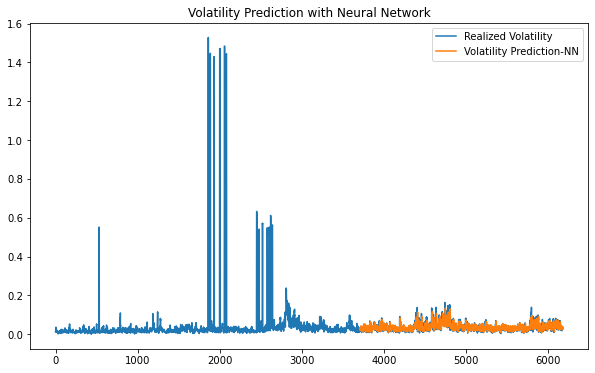

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(NN_predictions / 100, label='Volatility Prediction-NN')
plt.title('Volatility Prediction with Neural Network', fontsize=12)
plt.legend()
plt.show()

In [39]:
rmse_NN = np.sqrt(mse(realized_vol.iloc[-n:] / 100, NN_predictions / 100))
print('The RMSE value of NN is {:.6f}'.format(rmse_NN))

The RMSE value of NN is 0.008732


## TensorFlow

In [40]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error as mse

In [41]:
model = keras.Sequential([layers.Dense(256, activation="relu"),
                          layers.Dense(128, activation="relu"),
                          layers.Dense(1, activation="linear"),])

model.compile(loss='mse', optimizer='rmsprop')
epochs_trial = np.arange(100, 400, 4)
batch_trial = np.arange(100, 400, 4)
DL_pred = []
DL_RMSE = []
for i, j, k in zip(range(4), epochs_trial, batch_trial):
    model.fit(X.iloc[:-n].values,
              realized_vol.iloc[1:-(n-1)].values.reshape(-1,),
              batch_size=k, epochs=j, verbose=False)
    DL_predict = model.predict(np.asarray(X.iloc[-n:]))
    DL_RMSE.append(np.sqrt(mse(realized_vol.iloc[-n:] / 100,
                         DL_predict.flatten() / 100)))
    DL_pred.append(DL_predict)
    print('DL_RMSE_{}:{:.6f}'.format(i+1, DL_RMSE[i]))

DL_RMSE_1:0.005589
DL_RMSE_2:0.005703
DL_RMSE_3:0.007703
DL_RMSE_4:0.008126


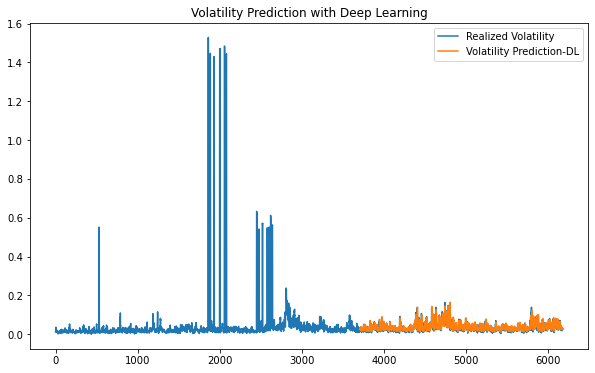

In [42]:
DL_predict = pd.DataFrame(DL_pred[DL_RMSE.index(min(DL_RMSE))])
DL_predict.index = returns.iloc[-n:].index

plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100,label='Realized Volatility')
plt.plot(DL_predict / 100,label='Volatility Prediction-DL')
plt.title('Volatility Prediction with Deep Learning',  fontsize=12)
plt.legend()
plt.show()

# Bayesian Approach

In [43]:
from scipy.stats import kurtosis
import pyflux as pf

Index    Latent Variable           Prior           Prior Hyperparameters     V.I. Dist  Transform 
======== ========================= =============== ========================= ========== ==========
0        Vol Constant              Normal          mu0: 0, sigma0: 3         Normal     exp       
1        q(1)                      Normal          mu0: 0, sigma0: 0.5       Normal     logit     
2        p(1)                      Normal          mu0: 0, sigma0: 0.5       Normal     logit     
3        Returns Constant          Normal          mu0: 0, sigma0: 3         Normal     None      
Acceptance rate of Metropolis-Hastings is 0.00605
Acceptance rate of Metropolis-Hastings is 0.22095
Acceptance rate of Metropolis-Hastings is 0.3058

Tuning complete! Now sampling.
Acceptance rate of Metropolis-Hastings is 0.2494
GARCH(1,1)                                                                                                
======================================================= =============

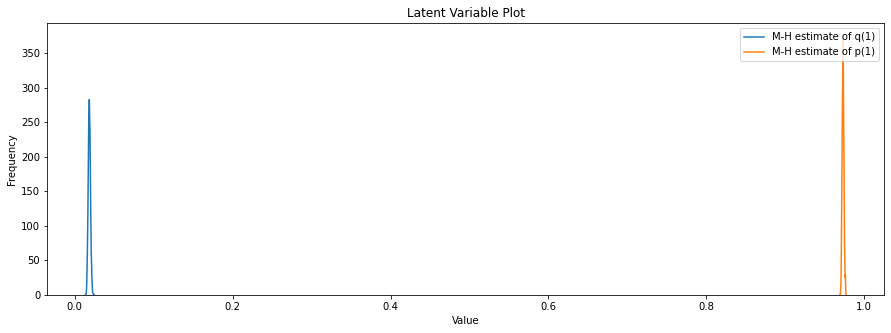

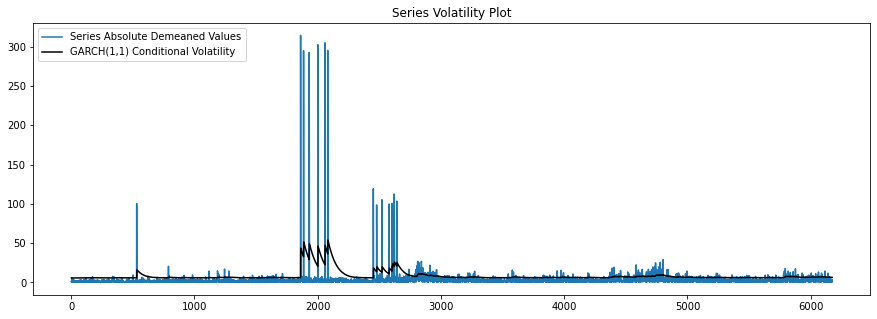

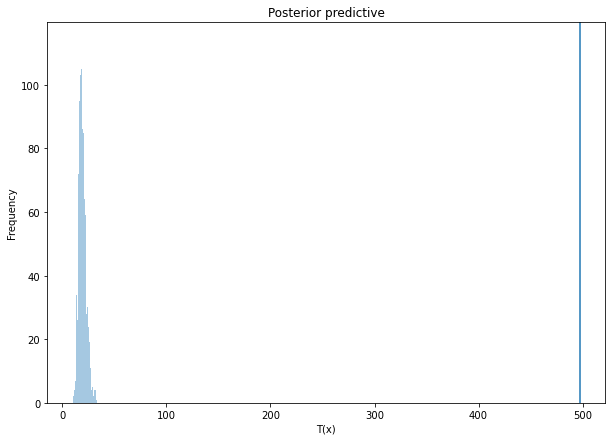

In [44]:
model = pf.GARCH(returns.values, p=1, q=1)
print(model.latent_variables)
model.adjust_prior(1, pf.Normal())
model.adjust_prior(2, pf.Normal())
x = model.fit(method='M-H', iterations='1000')
print(x.summary())

model.plot_z([1, 2])
model.plot_fit(figsize=(15, 5))
model.plot_ppc(T=kurtosis, nsims=1000)

In [45]:
#start = timeit.default_timer()

#bayesian_prediction = model.predict_is(n, fit_method='M-H')
#bayesian_RMSE = np.sqrt(mse(realized_vol.iloc[-n:] / 100, bayesian_prediction.values / 100))
#bayesian_prediction.index = returns.iloc[-n:].index

#stop = timeit.default_timer()
#print('Time: ', stop - start)

In [46]:
#plt.figure(figsize=(10, 6))
#plt.plot(realized_vol / 100, label='Realized Volatility')
#plt.plot(bayesian_prediction['Series'] / 100, label='Volatility Prediction-Bayesian')
#plt.title('Volatility Prediction with M-H Approach', fontsize=12)
#plt.legend()
#plt.show()

# RSME

In [47]:
print('The RMSE value of ARCH model is {:.4f}'.format(rmse_arch))
print('The RMSE value of GARCH model is {:.4f}'.format(rmse_garch))
print('The RMSE value of GJR-GARCH models is {:.4f}'.format(rmse_gjr_garch))
print('The RMSE value of EGARCH models is {:.4f}'.format(rmse_egarch))
print('The RMSE value of SVR with Linear Kernel is {:.6f}'.format(rmse_svr))
print('The RMSE value of SVR with RBF Kernel is  {:.6f}'.format(rmse_svr_rbf))
#print('The RMSE value of SVR with Polynomial Kernel is {:.6f}'.format(rmse_svr_poly))
print('The RMSE value of NN is {:.6f}'.format(rmse_NN))
print('The RMSE value of DL_RMSE is', DL_RMSE)
#print('The RMSE value of Bayesian_RMSE is {:.6f}'.format(bayesian_RMSE))

The RMSE value of ARCH model is 1.0553
The RMSE value of GARCH model is 0.6327
The RMSE value of GJR-GARCH models is 0.6158
The RMSE value of EGARCH models is 0.7756
The RMSE value of SVR with Linear Kernel is 0.000277
The RMSE value of SVR with RBF Kernel is  0.008561
The RMSE value of NN is 0.008732
The RMSE value of DL_RMSE is [0.005588949074724202, 0.005703328789864788, 0.007703302090884949, 0.008126412908416649]


# volatilty by 2%
True or False

# LSTM and ARIMA-GARCH
Up or down by how much

True + Up = 1 <br>
True + Down = 2 <br>
False + Up/Down = 3 <br>